In [51]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [52]:
import nltk
from nltk.stem import WordNetLemmatizer
from nltk.tag import pos_tag
from nltk.corpus import wordnet
from nltk.sentiment import SentimentIntensityAnalyzer
import spacy
from spacy import displacy
from spacy.matcher import Matcher
from collections import Counter
from collections import defaultdict
import string

In [53]:
# Download the required resources and initialize the NLP tools:
nltk.download('wordnet')
nltk.download('averaged_perceptron_tagger')
nltk.download('vader_lexicon')
nltk.download('punkt')
nlp = spacy.load('en_core_web_sm')

[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!
[nltk_data] Downloading package vader_lexicon to /root/nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


BOOK: Ulysses by James Joyce

TASK 2

In [54]:
# Define a function for lemmatization:
def lemmatize_word(word, tag):
    if tag.startswith('NN'):
        return wordnet.NOUN
    elif tag.startswith('VB'):
        return wordnet.VERB
    elif tag.startswith('JJ'):
        return wordnet.ADJ
    elif tag.startswith('RB'):
        return wordnet.ADV
    else:
        return None


def lemmatize_text(text):
    lemmatizer = WordNetLemmatizer()
    tagged_words = pos_tag(text)
    lemmatized_words = [
        lemmatizer.lemmatize(word, lemmatize_word(word, tag))
        if lemmatize_word(word, tag) is not None
        else lemmatizer.lemmatize(word)
        for word, tag in tagged_words
        if word.lower() not in string.punctuation and tag in ['NN', 'NNS'] and word != "’" and word != "s" and word != "t"
    ]
    return lemmatized_words

# https://cs.nyu.edu/~grishman/jet/guide/PennPOS.html


In [55]:
# Read and preprocess the text:
with open('/content/drive/My Drive/Colab Notebooks/Ulysses by James Joyce.txt', 'r', encoding='utf-8') as file:
    text = file.read()

# Preprocessing: Tokenization
text_tokens = nltk.word_tokenize(text)

# Preprocessing: Lemmatization
lemmatized_tokens = lemmatize_text(text_tokens)

In [56]:
# Perform named entity recognition (NER) using spaCy:
nlp.max_length = len(text)
doc = nlp(text)
ner_labels = set([ent.label_ for ent in doc.ents])

# Filter entities of interest (e.g., PERSON, ORG, etc.)
filtered_entities = [
    ent.text for ent in doc.ents
    if ent.label_ in ['PERSON', 'ORG']
]

In [57]:
# Count the occurrences of character names and key terms:
# Count the occurrences of character names
character_counts = Counter(filtered_entities)
main_characters = character_counts.most_common(7)

# Count the occurrences of key terms (lemmatized tokens)
key_term_counts = Counter(lemmatized_tokens)
main_terms = key_term_counts.most_common(7)

In [58]:
# Print character names and key terms:
print(main_characters)
print(main_terms)

[('Stephen', 144), ('Joe', 115), ('Dedalus', 104), ('Buck Mulligan', 89), ('Martin Cunningham', 70), ('Conmee', 51), ('Gerty', 49)]
[('hand', 436), ('eye', 433), ('man', 428), ('time', 428), ('day', 322), ('thing', 306), ('woman', 297)]


TASK 3

In [59]:
# Define a function to extract the main definitory features using dependency parsing:
def extract_definitory_features(token):
    features = []
    for chunk in token.subtree:
        if chunk.dep_ in ['amod', 'compound'] and chunk.ent_type_ not in ['PERSON', 'ORG', 'LOC']:
            features.append(chunk.text)
    return features[:7]

In [60]:
# Identify the main "voices" and their definitory features:
main_voices = main_characters

voice_definitory_features = {}
for voice in main_voices:
    voice_definitory_features[voice[0]] = []
    for token in doc:
        if token.text.lower() == voice[0].lower():
            features = extract_definitory_features(token)
            voice_definitory_features[voice[0]].extend(features)
    voice_definitory_features[voice[0]] = list(set(voice_definitory_features[voice[0]]))

In [61]:
# Print the main voices and their definitory features:
for voice, features in voice_definitory_features.items():
    print("Voice:", voice)
    print("Definitory Features:", features[:7])
    print()

Voice: Stephen
Definitory Features: ['middle', 'dead', 'accosting', 'throat', 'exaggerated', 'youthful', 'Mr']

Voice: Joe
Definitory Features: ['holy', 'racing', 'JOE', 'Decent', 'sports', 'little', 'fellow']

Voice: Dedalus
Definitory Features: ['Mr', 'dry', 'displeased', 'Dedalus', 'big', 'Div', 'featureless']

Voice: Buck Mulligan
Definitory Features: []

Voice: Martin Cunningham
Definitory Features: []

Voice: Conmee
Definitory Features: ['lord', 'house', 'jesuit', 'Father', 'JOHN', 'Old', 'Mall']

Voice: Gerty
Definitory Features: ['responded', 'halcyon', 'poor', 'higharched', 'delicate', 'christmas', 'young']



TASK 4

In [71]:
# Initialize the sentiment analyzer
sid = SentimentIntensityAnalyzer()

In [63]:
# Define a function to check if the interaction pattern matches
def is_interaction_pattern(doc):
    for match_id, start, end in matcher(doc):
        return True
    return False

In [64]:
# Identify the interactions between characters:
character_interactions = []
interacted_pairs = set()  # Track the pairs of characters that have already interacted

sentences = nltk.sent_tokenize(text)
matcher = Matcher(nlp.vocab)

In [65]:
# Iterate through the main characters and find their interactions within the text:
for i in range(len(main_voices)):
    for j in range(i + 1, len(main_voices)):
        character1 = main_voices[i][0]
        character2 = main_voices[j][0]

        # Check if the character pair has already interacted
        if (character1, character2) in interacted_pairs or (character2, character1) in interacted_pairs:
            continue

        pattern = [{'LOWER': character1.lower()}, {'DEP': 'prep'}, {'LOWER': character2.lower()}]
        matcher.add("InteractionPattern", [pattern])

        # Find sentences where both characters appear
        interactions = [sent for sent in sentences if character1 in sent and character2 in sent]

        # Perform dependency parsing on the interactions
        for interaction in interactions:
            doc = nlp(interaction)

            # Check if the interaction pattern matches
            matches = matcher(doc)
            if matches:
                interaction_type = "Agreement"
            else:
                sentiment_scores = sid.polarity_scores(interaction)
                if sentiment_scores['compound'] >= 0:
                    interaction_type = "Agreement"
                else:
                    interaction_type = "Disagreement"

            # Add the interaction between the characters to the list
            character_interactions.append((character1, character2, interaction, interaction_type))

        # Add the character pair to the set of interacted pairs
        interacted_pairs.add((character1, character2))

In [66]:
# Print the character interactions:
for interaction in character_interactions:
    character1, character2, interaction_text, interaction_type = interaction
    print(f"{character1} interacting with {character2}:")
    # print("Interaction:", interaction_text)
    print("Type of Interaction:", interaction_type)
    print()

Stephen interacting with Joe:
Type of Interaction: Agreement

Stephen interacting with Dedalus:
Type of Interaction: Disagreement

Stephen interacting with Dedalus:
Type of Interaction: Agreement

Stephen interacting with Dedalus:
Type of Interaction: Agreement

Stephen interacting with Dedalus:
Type of Interaction: Agreement

Stephen interacting with Dedalus:
Type of Interaction: Agreement

Stephen interacting with Dedalus:
Type of Interaction: Agreement

Stephen interacting with Dedalus:
Type of Interaction: Agreement

Stephen interacting with Dedalus:
Type of Interaction: Agreement

Stephen interacting with Dedalus:
Type of Interaction: Agreement

Stephen interacting with Dedalus:
Type of Interaction: Disagreement

Stephen interacting with Dedalus:
Type of Interaction: Agreement

Stephen interacting with Dedalus:
Type of Interaction: Disagreement

Stephen interacting with Dedalus:
Type of Interaction: Disagreement

Stephen interacting with Dedalus:
Type of Interaction: Agreement

St

TASK 5

In [67]:
import re
import xml.etree.ElementTree as ET

chapter_delimiter = "— "
section_delimiter = r"\n\n\[ "
paragraph_delimiter = "\n\n"
group_delimiter = "\n"

chapters = re.split(chapter_delimiter, text)[1:]

root = ET.Element("Novel")

for chapter in chapters:
    sections = re.split(section_delimiter, chapter)[1:]
    chapter_name = sections[0].strip().split(" ")[0]
    
    chapter_elem = ET.SubElement(root, "Chapter")
    chapter_elem.text = chapter_name

    for section in sections:
        paragraphs = re.split(paragraph_delimiter, section)
        section_name = paragraphs[0].strip().strip("[]")
        
        section_elem = ET.SubElement(chapter_elem, "Section")
        section_elem.text = section_name

        for paragraph in paragraphs[1:]:
            groups = re.split(group_delimiter, paragraph)

            paragraph_elem = ET.SubElement(section_elem, "Paragraph")
            
            for group in groups:
                segments = group.strip().split(". ")

                group_elem = ET.SubElement(paragraph_elem, "Group")

                for segment in segments:
                    segment_elem = ET.SubElement(group_elem, "Segment")
                    segment_elem.text = segment.strip()

tree = ET.ElementTree(root)
output_path = "/content/drive/My Drive/Colab Notebooks/ulysses.xml"
tree.write(output_path, encoding="utf-8", xml_declaration=True)


In [68]:
import xml.dom.minidom

xml_file_path = output_path

with open(xml_file_path, 'r', encoding='utf-8') as file:
    xml_content = file.read()

dom = xml.dom.minidom.parseString(xml_content)
pretty_xml = dom.toprettyxml(indent="    ")

output_file_path = "/content/drive/My Drive/Colab Notebooks/ulysses_pretty.xml"
with open(output_file_path, 'w', encoding='utf-8') as output_file:
    output_file.write(pretty_xml)



In [69]:
print(tree)

TASK 6

In [78]:
tree = ET.parse(xml_file_path)
root = tree.getroot()

# We defined "anphora" as the rhetorical schema that we want to analyse
rhetorical_schema = "anaphora"
instances = []

# Rhetorical schema analysis
for chapter_elem in root.findall("Chapter"):
    for section_elem in chapter_elem.findall("Section"):
        for paragraph_elem in section_elem.findall("Paragraph"):
            for group_elem in paragraph_elem.findall("Group"):
                segments = [segment_elem.text for segment_elem in group_elem.findall("Segment")]

                for i in range(1, len(segments)):
                    current_segment = segments[i]
                    previous_segment = segments[i-1]

                    if current_segment.startswith(previous_segment):
                        instances.append((current_segment, previous_segment))

for instance in instances:
    current_segment, previous_segment = instance
    print(f"Rhetorical Schema: {previous_segment} -> {current_segment}")
anaphora_counter = instances


Rhetorical Schema: Day!.. -> Day!..
Rhetorical Schema: Lal the ral the ra -> Lal the ral the raddy.
Rhetorical Schema: Thumping -> Thumping.
Rhetorical Schema: Clank it -> Clank it
Rhetorical Schema: Twentyeight -> Twentyeight double four.
Rhetorical Schema: J -> J
Rhetorical Schema: J -> J
Rhetorical Schema: J -> J
Rhetorical Schema: J -> J
Rhetorical Schema: J -> J
Rhetorical Schema: J -> J
Rhetorical Schema: J -> J
Rhetorical Schema: J -> J
Rhetorical Schema: J -> J
Rhetorical Schema: J -> J
Rhetorical Schema: J -> J
Rhetorical Schema: J -> J
Rhetorical Schema: J -> J
Rhetorical Schema: J -> J
Rhetorical Schema: Happy -> Happy.
Rhetorical Schema: Tea -> Tea
Rhetorical Schema: Tea -> Tea
Rhetorical Schema: Stop -> Stop
Rhetorical Schema: Six -> Six
Rhetorical Schema: Today -> Today
Rhetorical Schema: It is -> It is.
Rhetorical Schema: Smile -> Smile Cranly’s smile.
Rhetorical Schema: I paid my way -> I paid my way.
Rhetorical Schema: Buzz -> Buzz.
Rhetorical Schema: J -> J
Rhetorical

In [79]:
antithesis_counter = 0
for chapter_elem in root.iter("Chapter"):
    for section_elem in chapter_elem.iter("Section"):
        for paragraph_elem in section_elem.iter("Paragraph"):
            for group_elem in paragraph_elem.iter("Group"):
                segments = list(group_elem.iter("Segment"))

                for i in range(len(segments) - 1):
                    segment1 = segments[i].text
                    segment2 = segments[i + 1].text

                    # Check if the segments exhibit antithesis
                    if segment1 and segment2:
                        if ("not" in segment1 and "not" not in segment2) or ("no" in segment1 and "no" not in segment2) or ("never" in segment1 and "never" not in segment2):
                            print(f"Antithesis: {segment1} -> {segment2}")
                            antithesis_counter += 1


Antithesis: you’re not a gentleman -> God, these bloody English! Bursting with money
Antithesis: I’m not a hero, however -> If
Antithesis: mother? The snotgreen sea -> The scrotumtightening sea
Antithesis: Pain, that was not yet the pain of love, fretted his heart -> Silently,
Antithesis: and a few noserags -> How are the secondhand breeks?
Antithesis: knows what poxy bowsy left them off -> I have a lovely pair with a hair
Antithesis: I’m not joking, Kinch -> You
Antithesis: abroad in sunlight now radiant on the sea -> His curling shaven lips
Antithesis: Lead him not into temptation -> And her name is Ursula.
Antithesis: —The rage of Caliban at not seeing his face in a mirror, he said -> If
Antithesis: thinks you’re not a gentleman -> His old fellow made his tin by selling
Antithesis: that knows what you are -> Why don’t you trust me more? What have you up
Antithesis: they hold their ribs with laughter, one clasping another -> O, I shall
Antithesis: the water like the snout of a sleepi

In [85]:
chiasmus_counter = 0
for chapter_elem in root.findall('Chapter'):
    for section_elem in chapter_elem.findall('Section'):
        for paragraph_elem in section_elem.findall('Paragraph'):
            for group_elem in paragraph_elem.findall('Group'):
                segments = group_elem.findall('Segment')
                
                for i in range(1, len(segments)):
                    segment1 = segments[i - 1].text
                    segment2 = segments[i].text
                    
                    if segment1[::-1] == segment2:
                        chiasmus_counter += 1
                        print("Chiasmus found!")
                        print("Segment 1:", segment1)
                        print("Segment 2:", segment2)
                        print()

Chiasmus found!
Segment 1: J
Segment 2: J

Chiasmus found!
Segment 1: J
Segment 2: J

Chiasmus found!
Segment 1: J
Segment 2: J

Chiasmus found!
Segment 1: J
Segment 2: J

Chiasmus found!
Segment 1: J
Segment 2: J

Chiasmus found!
Segment 1: J
Segment 2: J

Chiasmus found!
Segment 1: J
Segment 2: J

Chiasmus found!
Segment 1: J
Segment 2: J

Chiasmus found!
Segment 1: J
Segment 2: J

Chiasmus found!
Segment 1: J
Segment 2: J

Chiasmus found!
Segment 1: J
Segment 2: J

Chiasmus found!
Segment 1: J
Segment 2: J

Chiasmus found!
Segment 1: J
Segment 2: J

Chiasmus found!
Segment 1: J
Segment 2: J

Chiasmus found!
Segment 1: J
Segment 2: J

Chiasmus found!
Segment 1: P
Segment 2: P

Chiasmus found!
Segment 1: J
Segment 2: J

Chiasmus found!
Segment 1: J
Segment 2: J

Chiasmus found!
Segment 1: J
Segment 2: J

Chiasmus found!
Segment 1: J
Segment 2: J

Chiasmus found!
Segment 1: J
Segment 2: J

Chiasmus found!
Segment 1: J
Segment 2: J



In [74]:
import xml.etree.ElementTree as ET
import itertools

tree = ET.parse(xml_file_path)
root = tree.getroot()

chiasmus_patterns = []

segments = root.findall("Segment")

for i, segment_elem in enumerate(segments):
    segment_text = segment_elem.text.strip()
    
    if len(segment_text) >= 2:
        if segment_text[0] == segment_text[-1]:
            reversed_segment_text = segment_text[::-1]
            
            for next_segment_elem in segments[i+1:]:
                if next_segment_elem.text.strip() == reversed_segment_text:
                    # Chiasmus pattern found
                    chiasmus_patterns.append((segment_text, reversed_segment_text))
                    break
if chiasmus_patterns:
    print("Chiasmus patterns found:")
    for pattern in chiasmus_patterns:
        print("Segment 1:", pattern[0])
        print("Segment 2:", pattern[1])
        print()
else:
    print("No chiasmus patterns found.")


No chiasmus patterns found.


In [82]:
print(len(anaphora_counter))

85


In [83]:
print(antithesis_counter)

895


In [86]:
print(chiasmus_counter)

22


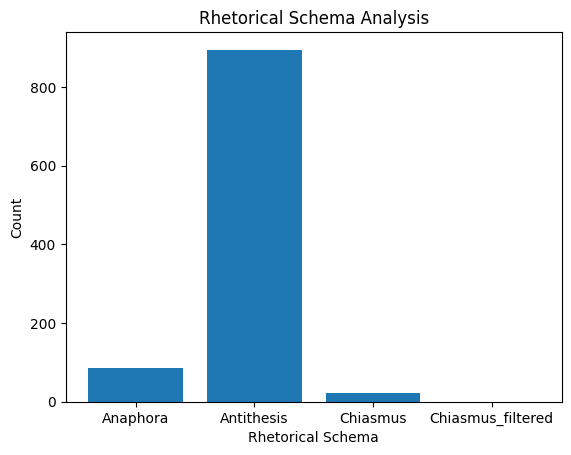

In [87]:
import matplotlib.pyplot as plt

chiasmus_counter_f = 0

labels = ['Anaphora', 'Antithesis', 'Chiasmus', 'Chiasmus_filtered']
counts = [len(anaphora_counter), antithesis_counter, chiasmus_counter, chiasmus_counter_f]

plt.bar(labels, counts)
plt.xlabel('Rhetorical Schema')
plt.ylabel('Count')
plt.title('Rhetorical Schema Analysis')

plt.show()
